<h1>The Titanic Dataset : can we predict how survive ?

<h2>1. Imports & first explorations

Let's start with the imports we will need for this work !

In [263]:
import pandas as pd
import numpy as np
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn import tree

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer

print('Setup completed')

Setup completed


Then we will make the next ligns to import our data, we will repeat these lines of code to reimport our data everytime we want to test new things on our data.

In [209]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
index_test = test.PassengerId
X_train = train.drop(columns=['Survived'], axis=1)
y_train = train.Survived
print('Data is ready')

Data is ready


In [179]:
X_train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<h2>2. First model without feature engineering.
<h4>We are only going to consider 'main' features and erase the others, and we wille have our first model.

In [210]:
X_train = X_train.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
X_train = pd.get_dummies(X_train, drop_first=True)
X_train.head(3)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True


On doit désormais imputer nos données car il nous en manque, notamment dans la colonne 'Age'. Pour cela on va utiliser les imputers de sklearn.

In [211]:
num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
imputer=impute.IterativeImputer()
imputer.fit(X_train[num_cols])
imputed=imputer.transform(X_train[num_cols])
X_train.loc[:,num_cols]=imputed


In [182]:
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True


On peut désormais standardiser nos données, toutefois on ne va pas standardiser nos colonnes factices.

In [212]:
scaler=preprocessing.StandardScaler()
cols= "Pclass,Age,SibSp,Parch,Fare".split(",")

scaler.fit(X_train[cols])
X_train.loc[:,cols] = scaler.transform(X_train[cols]).astype('int64')

<Axes: >

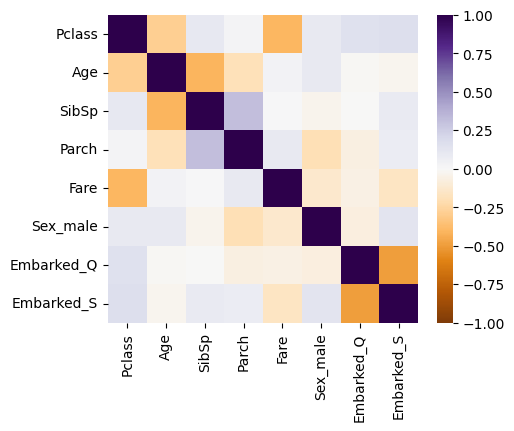

In [197]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = X_train.corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )

In [198]:
for model in [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=4)
    s=model_selection.cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=kfold)
    print(
        f"{model.__name__:22} AUC:"
        f"{s.mean():.3f}    STD:  {s.std():.2f}"
    )

DummyClassifier        AUC:0.500    STD:  0.00
LogisticRegression     AUC:0.853    STD:  0.03
DecisionTreeClassifier AUC:0.838    STD:  0.05
KNeighborsClassifier   AUC:0.825    STD:  0.04
GaussianNB             AUC:0.817    STD:  0.03
SVC                    AUC:0.807    STD:  0.04
RandomForestClassifier AUC:0.854    STD:  0.04
XGBClassifier          AUC:0.849    STD:  0.04


Looking at the results, we want to pursue the idea of a Random Forest Classifier. We are going now to create the model and try to optimize through the values of the hyperparameters, and to explore it we are going to use a Grid Search.

In [186]:
rf=RandomForestClassifier(random_state=4)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

grid = model_selection.GridSearchCV(rf, param_grid=param_grid, cv=kfold)

grid.fit(X_train,y_train)

,estimator,RandomForestC...andom_state=4)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [199]:
print(grid.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [202]:
def process(df):
    df=df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])
    df=pd.get_dummies(df, drop_first=True)
    num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    df[num_cols] = df[num_cols].astype(float)
    imputed=imputer.transform(df[num_cols])
    df.loc[:,num_cols]=imputed

    cols= "Pclass,Age,SibSp,Parch,Fare".split(",")
    df.loc[:,cols] = scaler.transform(df[cols])

    return df

In [207]:
rf_final = RandomForestClassifier ( max_depth=5,  max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_final.fit(X_train,y_train)
pd.DataFrame(rf_final.predict(X_train),index=train.PassengerId, columns=["Survived"]).value_counts()

Survived
0           578
1           313
Name: count, dtype: int64

In [ ]:
rf_final = RandomForestClassifier ( max_depth=5,  max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_final.fit(X_train,y_train)

test=process(test)

y_pred=rf_final.predict(test)
pred=pd.DataFrame(y_pred, index=index_test, columns=["Survived"])
#pred.to_csv('titanic_pred.csv')
pred.head()

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

<h2> 3. Feature Engineering : creation of new variables

I submitted the 'rf_final' model to Kaggle and I received a 0,77 accuracy. It looks like it is a usual score for the dataset, although there is still some new things that I could add to continue to improve the model. One of the leads could be feature engeenering, in other words create new features like Title, or family size. I would also like to try to make a clean sklearn pipeline with the class Pipeline and ColumnTransformer.

In [343]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = pd.concat([train,test])
index_test = test.PassengerId
X_train = train.drop(columns=['Survived'], axis=1)
#y_train = train.Survived --> Because we are going to erase a few rows after
print('Data is ready')

Data is ready


<h3>New columns : Title, Family, IsAlone, Cabin ...<h3>

In [344]:
data['Title'] = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
rare_titles = ['Don','Rev', 'Dr', 'Major', 'Jonkheer', 'Lady', 'Sir', 'the Countess', 'Ms', 'Capt', 'Col', ]
data.Title = data.Title.replace(rare_titles, 'Rare')
data.Title = data.Title.replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Dona'], dtype=object)

In [345]:
data['Family']=data.Parch+data.SibSp+1
data['IsAlone']=(data.Family==1).astype('int64')

Now the goal is also to extract new informations from the Cabin and maybe the ticket feature !

In [346]:
data['cabin_adv'] = data.Cabin.apply(lambda x: str(x)[0]) #Position of the cabin + have they a cabin ?
data['cabin_nb'] = data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' '))) #Did they have multiple cabins ?


We need to impute the datas now. And I will try to do it with a different method now. I am going to check what features we need to impute in the test dataset and I will try to impute the Age in a better way. For exemple, I am going to try to impute the Age according to the Title of the person. It will be more precise for the Rare or the Master title.

In [347]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Ok so the problem seems the same, although we have also a Fare missing value but we will fill it with the mean !

In [348]:
for title in data['Title'].unique():
    mask = (data['Title'] == title) & (data['Age'].isna())
    mean_age = X_train.loc[data.iloc[:X_train.shape[0]]['Title'] == title, 'Age'].mean()
    data.loc[mask, 'Age'] = mean_age

We imputed all of the Age missing values !

In [349]:
data.isnull().sum() 

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
Family            0
IsAlone           0
cabin_adv         0
cabin_nb          0
dtype: int64

In [350]:
data.Fare=data.Fare.fillna(X_train.Fare.mean())
data.dropna(subset=['Embarked'],inplace = True)
l = X_train.shape[0]
y_train = data.iloc[:l-2].Survived
data['norm_fare'] = np.log(data.Fare+1)
data.Pclass=data.Pclass.apply(lambda x: str(x))
data.Pclass.dtype

dtype('O')

We are now going to encode/scale our data according if they are categorical or numerical !

In [351]:
categorical = ['Pclass', 'Sex', 'Embarked', 'cabin_adv', 'Title']
numerical = ['Age', 'SibSp', 'Parch', 'norm_fare']

dummies = pd.get_dummies(data[categorical])

all_features = pd.concat([data[numerical], dummies], axis=1)


scaler = StandardScaler()
all_features[numerical] = scaler.fit_transform(all_features[numerical])

In [352]:
X_scaled = all_features.iloc[:l-2] #Because I erased two rows with the missing values of Embarked
X_test_scaled = all_features.iloc[l-2::,]

<h3>Test of model : baseline without finetuning

In [353]:
#Used as a baseline
gnb = GaussianNB()
cv = cross_val_score(gnb,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.70786517 0.71910112 0.73033708 0.76404494 0.76404494 0.74157303
 0.78651685 0.75280899 0.82022472 0.75      ]
0.7536516853932584


In [354]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.80898876 0.84269663 0.7752809  0.86516854 0.82022472 0.76404494
 0.80898876 0.83146067 0.88764045 0.85227273]
0.8256767109295199


In [355]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.70786517 0.79775281 0.71910112 0.79775281 0.84269663 0.78651685
 0.83146067 0.71910112 0.79775281 0.80681818]
0.780681818181818


In [356]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.76404494 0.80898876 0.73033708 0.83146067 0.86516854 0.82022472
 0.80898876 0.79775281 0.86516854 0.80681818]
0.8098953013278857


In [357]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.78651685 0.83146067 0.74157303 0.83146067 0.84269663 0.83146067
 0.79775281 0.7752809  0.85393258 0.84090909]
0.8133043922369765


In [358]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.83146067 0.85393258 0.75280899 0.87640449 0.84269663 0.79775281
 0.82022472 0.7752809  0.87640449 0.85227273]
0.8279239019407558


In [359]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.78651685 0.84269663 0.75280899 0.83146067 0.84269663 0.78651685
 0.83146067 0.79775281 0.86516854 0.82954545]
0.8166624106230846


In [360]:
gbc = GradientBoostingClassifier()
cv = cross_val_score(gbc, X_scaled, y_train,cv=10)
print(cv)
print(cv.mean())

[0.80898876 0.83146067 0.76404494 0.86516854 0.87640449 0.83146067
 0.84269663 0.80898876 0.91011236 0.84090909]
0.838023493360572


In [361]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft')
cv = cross_val_score(voting_clf,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.83146067 0.83146067 0.76404494 0.87640449 0.83146067 0.83146067
 0.80898876 0.80898876 0.87640449 0.875     ]
0.8335674157303371


In [333]:
voting_clf.fit(X_scaled, y_train)
y_pred = voting_clf.predict(X_test_scaled).astype(int)

pred=pd.DataFrame(y_pred, index=index_test, columns=["Survived"])
pred.to_csv('predictions/v_clf1_submission.csv')
pred.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [362]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_scaled,y_train)

y_pred = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
pred=pd.DataFrame(y_pred, index=index_test, columns=["Survived"])
pred.to_csv('predictions/xbg1_submission.csv')
pred.head()

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [363]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)  # Garde les 10 meilleures features
X_new = selector.fit_transform(X_scaled, y_train)
X_test_new = selector.transform(X_test_scaled)

new_best_clf_xgb = clf_xgb.fit(X_new,y_train)

y_pred = new_best_clf_xgb.best_estimator_.predict(X_test_new).astype(int)
pred=pd.DataFrame(y_pred, index=index_test, columns=["Survived"])
pred.to_csv('predictions/xbg3_submission.csv')
pred.head()

/opt/miniconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Fitting 10 folds for each of 243 candidates, totalling 2430 fits


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


We are going to try to finetune all of our models to to againg a voting classifier !

In [365]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [389]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Logistic Regression
Best Score: 0.8335546475995915
Best Parameters: {'C': np.float64(0.615848211066026), 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [390]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
KNN
Best Score: 0.8312946884576098
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [391]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 10 folds for each of 55 candidates, totalling 550 fits
SVC
Best Score: 0.8313074565883556
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}


In [ ]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['log2','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


<Axes: >

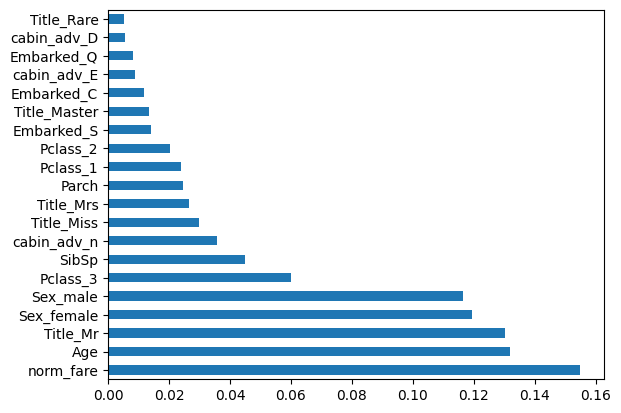

In [374]:
best_rf = best_clf_rf.best_estimator_.fit(X_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [393]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
XGB
Best Score: 0.8447522982635343
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 450, 'reg_alpha': 1, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.6}


In [395]:
gbc = GradientBoostingClassifier()


param_grid = {
    'n_estimators': [100, 200],           # Nombre d'arbres
    'learning_rate': [0.05, 0.1],        # Taux d'apprentissage (plus petit = plus lent mais plus précis)
    'max_depth': [3, 4],                    # Profondeur max de chaque arbre
    'min_samples_split': [2, 5, 10],           # Nb min d’échantillons pour diviser un noeud
    'min_samples_leaf': [1, 3, 5],             # Nb min d’échantillons dans une feuille
    'subsample': [0.8, 1.0],                   # Pour le "stochastic gradient boosting"
    'max_features': ['sqrt', 'log2', None],    # Nombre de features à considérer à chaque split
}

clf_gbc = GridSearchCV(gbc, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_gbc = clf_gbc.fit(X_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
XGB
Best Score: 0.8447522982635343
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 450, 'reg_alpha': 1, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.6}


In [396]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_
best_gbc = best_clf_gbc.best_estimator_

In [397]:
voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('gbc', best_gbc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('gbc', best_gbc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr), ('gbc', best_gbc)], voting = 'soft') 
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr), ('gbc', best_gbc)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_scaled,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_scaled,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_scaled,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_scaled,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_scaled,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_scaled,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_scaled,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_scaled,y_train,cv=5).mean())

voting_clf_hard : [0.8258427  0.80898876 0.86516854 0.79775281 0.86440678]
voting_clf_hard mean : 0.8324382657271631
voting_clf_soft : [0.82022472 0.80898876 0.85955056 0.79775281 0.87570621]
voting_clf_soft mean : 0.831321018218752
voting_clf_all : [0.82022472 0.80898876 0.84831461 0.79213483 0.87570621]
voting_clf_all mean : 0.829073827207516
voting_clf_xgb : [0.8258427  0.82022472 0.84269663 0.79213483 0.8700565 ]
voting_clf_xgb mean : 0.8324382657271631


In [398]:
voting_clf_hard.fit(X_scaled, y_train)
voting_clf_soft.fit(X_scaled, y_train)
voting_clf_all.fit(X_scaled, y_train)
voting_clf_xgb.fit(X_scaled, y_train)

,estimators,"[('knn', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,1


In [399]:
y_clf_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_clf_xgb = voting_clf_xgb.predict(X_test_scaled).astype(int)
y_clf_soft = voting_clf_soft.predict(X_test_scaled).astype(int)
y_clf_all = voting_clf_all.predict(X_test_scaled).astype(int)

In [400]:
pred_clf_hard = pd.DataFrame(y_clf_hard, index=index_test, columns=["Survived"])
pred_clf_xgb  = pd.DataFrame(y_clf_xgb, index=index_test, columns=["Survived"])
pred_clf_soft = pd.DataFrame(y_clf_soft, index=index_test, columns=["Survived"])
pred_clf_all  = pd.DataFrame(y_clf_all,  index=index_test, columns=["Survived"])

In [401]:
pred_clf_hard.to_csv("predictions/voting_hard.csv")
pred_clf_xgb.to_csv("predictions/voting_xgb.csv")
pred_clf_soft.to_csv("predictions/voting_soft.csv")
pred_clf_all.to_csv("predictions/voting_all.csv")